In [3]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from shutil import copy, copytree, rmtree
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import coremltools as ct

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array




dataset_path = "../dataset/food-101/"
print("Directories in dataset:", os.listdir(dataset_path))

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))



TensorFlow version 2.15.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.


Directories in dataset: ['.DS_Store', 'images', 'meta', 'license_agreement.txt', 'README.txt']
TensorFlow version: 2.15.0
Is GPU available? []


In [11]:
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [line.strip() for line in txt.readlines()]
        for path in paths:
            food, image = path.split('/')
            classes_images[food].append(image + '.jpg')

    for food in classes_images:
        print(f"\nCopying images into {food}")
        dest_dir = os.path.join(dest, food)
        os.makedirs(dest_dir, exist_ok=True)
        for image in classes_images[food]:
            src_path = os.path.join(src, food, image)
            dest_path = os.path.join(dest, food, image)
            copy(src_path, dest_path)
    print("Copying Done!")

def dataset_mini(food_list, src, dest):
    # Remove destination directory if it exists
    if os.path.exists(dest):
        rmtree(dest)  # Clean up the previous mini-dataset
    os.makedirs(dest)  # Create the destination folder

    # Copy selected categories to the new directory
    for food_item in food_list:
        print(f"Copying images into {food_item}")
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))





In [13]:
# Define paths
src_dir = '../dataset/food-101/images'
train_dir = '../dataset/food-101/train'
test_dir = '../dataset/food-101/test'

# Prepare training data
prepare_data('../dataset/food-101/meta/train.txt', src_dir, train_dir)

# Prepare testing data
prepare_data('../dataset/food-101/meta/test.txt', src_dir, test_dir)



Copying images into apple_pie

Copying images into baby_back_ribs

Copying images into baklava

Copying images into beef_carpaccio

Copying images into beef_tartare

Copying images into beet_salad

Copying images into beignets

Copying images into bibimbap

Copying images into bread_pudding

Copying images into breakfast_burrito

Copying images into bruschetta

Copying images into caesar_salad

Copying images into cannoli

Copying images into caprese_salad

Copying images into carrot_cake

Copying images into ceviche

Copying images into cheesecake

Copying images into cheese_plate

Copying images into chicken_curry

Copying images into chicken_quesadilla

Copying images into chicken_wings

Copying images into chocolate_cake

Copying images into chocolate_mousse

Copying images into churros

Copying images into clam_chowder

Copying images into club_sandwich

Copying images into crab_cakes

Copying images into creme_brulee

Copying images into croque_madame

Copying images into cup_ca

In [49]:
# Specify the categories for the mini-dataset
food_list = ['cheesecake', 'chocolate_cake', 'chocolate_mousse', 'fish_and_chips', 'french_fries', 'fried_calamari', 'fried_rice', 'gyoza', 'hamburger', 'hot_dog', 'oysters', 'pho', 'pizza', 'sushi', 'tacos']


# Paths for train and test subsets
src_train = '../dataset/food-101/train'
dest_train = '../dataset/food-101/train_mini'
src_test = '../dataset/food-101/test'
dest_test = '../dataset/food-101/test_mini'

# Create the mini-dataset
dataset_mini(food_list, src_train, dest_train)
dataset_mini(food_list, src_test, dest_test)

train_dir = '../dataset/food-101/train_mini'
test_dir = '../dataset/food-101/test_mini'


Copying images into cheesecake
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into fish_and_chips
Copying images into french_fries
Copying images into fried_calamari
Copying images into fried_rice
Copying images into gyoza
Copying images into hamburger
Copying images into hot_dog
Copying images into oysters
Copying images into pho
Copying images into pizza
Copying images into sushi
Copying images into tacos
Copying images into cheesecake
Copying images into chocolate_cake
Copying images into chocolate_mousse
Copying images into fish_and_chips
Copying images into french_fries
Copying images into fried_calamari
Copying images into fried_rice
Copying images into gyoza
Copying images into hamburger
Copying images into hot_dog
Copying images into oysters
Copying images into pho
Copying images into pizza
Copying images into sushi
Copying images into tacos


In [50]:
# Image dimensions
img_size = (224, 224)
batch_size = 64

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation data (only rescaling)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
valid_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 11250 images belonging to 15 classes.
Found 3750 images belonging to 15 classes.


In [51]:
# Load MobileNetV2 with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
175/175 [==============================] - 109s 615ms/step - loss: 1.8046 - accuracy: 0.4541 - val_loss: 0.7598 - val_accuracy: 0.7718
Epoch 2/30
175/175 [==============================] - 107s 612ms/step - loss: 1.1595 - accuracy: 0.6353 - val_loss: 0.6709 - val_accuracy: 0.7866
Epoch 3/30
175/175 [==============================] - 108s 614ms/step - loss: 1.0587 - accuracy: 0.6682 - val_loss: 0.5901 - val_accuracy: 0.8187
Epoch 4/30
175/175 [==============================] - 107s 611ms/step - loss: 0.9983 - accuracy: 0.6818 - val_loss: 0.5601 - val_accuracy: 0.8225
Epoch 5/30
175/175 [==============================] - 108s 618ms/step - loss: 0.9516 - accuracy: 0.7003 - val_loss: 0.5649 - val_accuracy: 0.8233
Epoch 6/30
175/175 [==============================] - 109s 623ms/step - loss: 0.9344 - accuracy: 0.7047 - val_loss: 0.5412 - val_accuracy: 0.8297
Epoch 7/30
175/175 [==============================] - 109s 624ms/step - loss: 0.9291 - accuracy: 0.7068 - val_loss: 0.5402 -

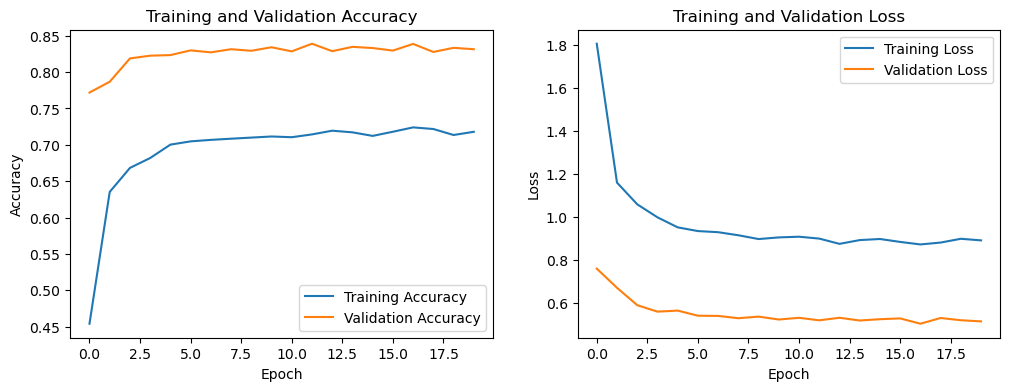

59/59 [==============================] - 19s 314ms/step - loss: 0.5047 - accuracy: 0.8379
Validation Accuracy: 0.84


In [53]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")

In [54]:
model.save('FoodClassifier_15.h5')


/Users/tuomasier/miniconda3/envs/cv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [55]:
model = load_model('FoodClassifier_15.h5')



In [56]:
mlmodel = ct.convert(model, inputs=[ct.ImageType(shape=(1, 224, 224, 3))])  # Adjust shape as per your model

# Save the Core ML model
mlmodel.save('FoodClassifier_15.mlpackage')

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 234.26 passes/s]


In [57]:
# Path to the test images
test_dir = '../dataset/real_test'
img_size = (224, 224)  # Same size used for training

# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=img_size)  # Load and resize image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale pixel values to [0, 1]
    return img_array

In [58]:
# Get class labels from the training generator
class_labels = list(train_generator.class_indices.keys())
# Predict and display results
for image_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_name)
    img_array = preprocess_image(image_path)
    
    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions) * 100  # Confidence score

    print(f"Image: {image_name} -> Predicted Class: {predicted_class} ({confidence:.2f}% confidence)")
    print("----: ", predictions)

1/1 [==============================] - 0s 373ms/step
Image: s4.jpg -> Predicted Class: pizza (50.39% confidence)
----:  [[1.02297097e-04 1.53960893e-04 1.82904754e-04 2.86373630e-04
  1.62099113e-05 6.75754482e-03 1.79527663e-02 4.15806007e-03
  4.19827848e-04 1.10899517e-03 1.19690254e-01 1.34918094e-02
  5.03945529e-01 3.60451266e-02 2.95688391e-01]]
1/1 [==============================] - 0s 26ms/step
Image: s1.jpg -> Predicted Class: sushi (99.83% confidence)
----:  [[6.3930788e-06 4.9691203e-06 6.1245159e-06 3.5722602e-05 7.2138530e-05
  5.9879699e-04 1.0961049e-05 1.4582531e-04 3.2073632e-04 7.4447613e-05
  3.0996450e-04 4.0566309e-07 8.4051026e-05 9.9825257e-01 7.6932745e-05]]
1/1 [==============================] - 0s 26ms/step
Image: s3.jpg -> Predicted Class: sushi (68.12% confidence)
----:  [[2.57525616e-03 2.65336619e-03 1.55898873e-02 1.50580104e-06
  1.14772965e-05 1.72206419e-05 1.85779252e-04 1.39793570e-04
  1.50819833e-04 2.29719840e-03 2.74977505e-01 1.97453250e-04
  9

In [63]:
print(class_labels)


['cheese_plate', 'cheesecake', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'fish_and_chips', 'french_fries', 'french_toast', 'fried_calamari', 'fried_rice', 'gyoza', 'hamburger', 'hot_dog', 'ice_cream', 'omelette', 'oysters', 'peking_duck', 'pho', 'pizza', 'sushi', 'tacos', 'waffles']


In [67]:

# Load your Core ML model
coreml_model = ct.models.MLModel("FoodClassifier_15_1.mlpackage")


# Define class labels (from your training generator)
class_labels = ['cheesecake', 'chocolate_cake', 'chocolate_mousse', 'fish_and_chips', 'french_fries', 'fried_calamari', 'fried_rice', 'gyoza', 'hamburger', 'hot_dog', 'oysters', 'pho', 'pizza', 'sushi', 'tacos']


# Preprocess the image for Core ML
def preprocess_image_coreml(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert("RGB").resize(target_size)
    return img  # Return the PIL.Image object



In [69]:
# Loop through test images

for image_name in os.listdir(test_dir):
    image_path = os.path.join(test_dir, image_name)
    
    # TensorFlow prediction
    img_array_tf = preprocess_image(image_path)
    predictions_tf = model.predict(img_array_tf)
    predicted_class_tf = class_labels[np.argmax(predictions_tf)]
    confidence_tf = np.max(predictions_tf) * 100  # Confidence score
    
    # Core ML prediction
    img_array_coreml = preprocess_image_coreml(image_path)
    result_coreml = coreml_model.predict({"input_4": img_array_coreml})
    
    # result_coreml["Identity"] is a dict: {class_label: probability}
    predictions_dict_coreml = result_coreml["Identity"]
    
    # Convert this dictionary into an array following the order in class_labels
    predictions_coreml = np.array([predictions_dict_coreml[label] for label in class_labels])
    
    predicted_class_coreml = class_labels[np.argmax(predictions_coreml)]
    confidence_coreml = np.max(predictions_coreml) * 100  # Confidence score

    # Display results
    print(f"Image: {image_name}")
    print(f"  TensorFlow - Predicted Class: {predicted_class_tf} ({confidence_tf:.2f}% confidence)")
    print(f"  Core ML - Predicted Class: {predicted_class_coreml} ({confidence_coreml:.2f}% confidence)")
    print("-" * 50)



1/1 [==============================] - 0s 28ms/step
Image: s4.jpg
  TensorFlow - Predicted Class: pizza (50.39% confidence)
  Core ML - Predicted Class: tacos (43.85% confidence)
--------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Image: s1.jpg
  TensorFlow - Predicted Class: sushi (99.83% confidence)
  Core ML - Predicted Class: sushi (99.90% confidence)
--------------------------------------------------
1/1 [==============================] - 0s 24ms/step
Image: s3.jpg
  TensorFlow - Predicted Class: sushi (68.12% confidence)
  Core ML - Predicted Class: sushi (88.38% confidence)
--------------------------------------------------
1/1 [==============================] - 0s 23ms/step
Image: s2.jpg
  TensorFlow - Predicted Class: sushi (93.86% confidence)
  Core ML - Predicted Class: sushi (82.28% confidence)
--------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Image: p3.jpg
  TensorFlow -

In [65]:
# Define the input type with preprocessing parameters
# Normalize the image to [-1, 1] as expected by the MobileNet model
image_input = ct.ImageType(
    shape=(1, 224, 224, 3),  # Input shape (batch, height, width, channels)
    bias=[-1, -1, -1],       # Subtract 1 from each channel to map [0,1] -> [-1,0]
    scale=1/127.0,           # Scale pixel values to [-1, 1]
    color_layout="RGB"       # Use RGB channel layout
)

# Define class labels
class_labels = ['cheesecake', 'chocolate_cake', 'chocolate_mousse', 'fish_and_chips', 'french_fries', 'fried_calamari', 'fried_rice', 'gyoza', 'hamburger', 'hot_dog', 'oysters', 'pho', 'pizza', 'sushi', 'tacos']


# Add classifier configuration to map the output index to class labels
classifier_config = ct.ClassifierConfig(class_labels)

# Convert the Keras model to Core ML
coreml_model = ct.convert(
    model,                       # Your trained Keras model
    convert_to="neuralnetwork",        # Convert to Core ML neural network
    inputs=[image_input],              # Use the defined input type
    classifier_config=classifier_config  # Add classifier configuration
)

# Save the converted Core ML model
coreml_model.save("FoodClassifier_15_1.mlpackage")


Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 487/487 [00:00<00:00, 4201.58 ops/s]
